In [1]:
#pip install pyocclient

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for pyocclient: filename=pyocclient-0.6-py3-none-any.whl size=26080 sha256=aeb66396bd34145dcfa570a03ad41dfc80b2f74cd64de000df7d77c9e7900650
  Stored in directory: /tmp/pip-ephem-wheel-cache-vbxsm5u8/wheels/79/c2/ab/1835c43b138eb68a870c744df40ce83e1466bea76898b3a943
Successfully built pyocclient
Note: you may need to restart the kernel to use updated packages.


In [2]:
import owncloud


In [3]:
#!pip install pillow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
# Import dependencies
import os
import numpy as np
from matplotlib import pyplot as plt

import skimage.io as skio

## Basics of image (pre)processing

/tmp/ipykernel_489/3479303637.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(image)


(np.float64(-0.5), np.float64(1349.5), np.float64(1484.5), np.float64(-0.5))

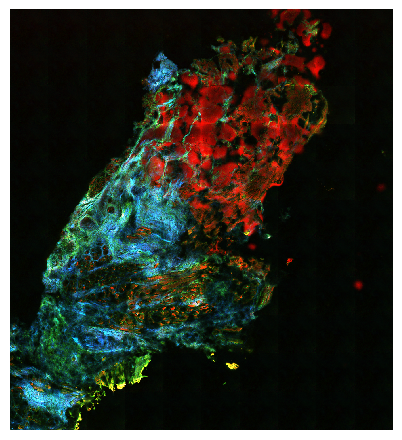

In [5]:
image = skio.imread('./data/example_image.png')

skio.imshow(image)
plt.axis('off')

In [6]:
### Normalization: important for modeling, depending on the model being used
# transform from 0~255 to 0~1
image_0_1 = image / 255.
print("Range normalizated image  : ", np.min(image_0_1), np.max(image_0_1))

# transform from 0~255 to -1~1
image_neg1_1 = (image - 127.5) / 127.5
print("Range normalizated image  : ", np.min(image_neg1_1), np.max(image_neg1_1))

Range normalizated image  :  0.0 1.0
Range normalizated image  :  -1.0 1.0


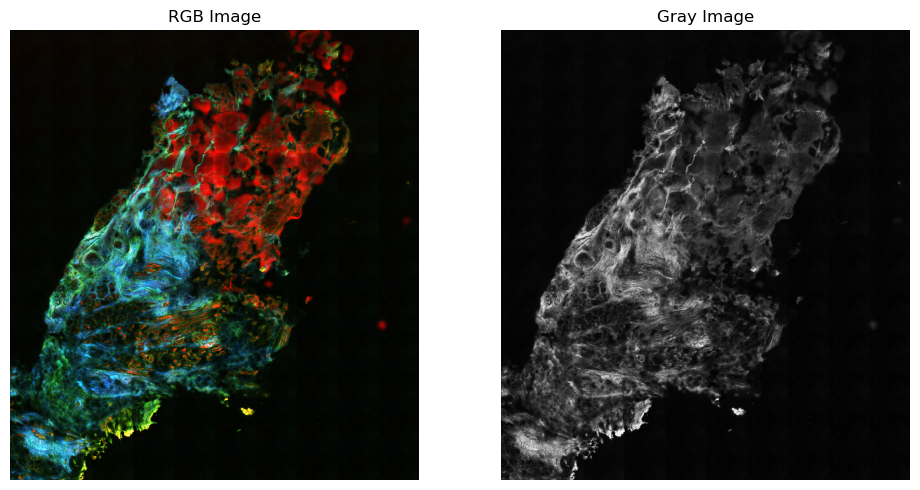

In [7]:
### Convert RGB into gray-level image
from skimage.color import rgb2gray
image_gray = rgb2gray(image)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('RGB Image')

ax[1].imshow(image_gray, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Gray Image')
plt.tight_layout()
plt.show()

### Alternatively, use `Gray = a * R + b * G + c * B`

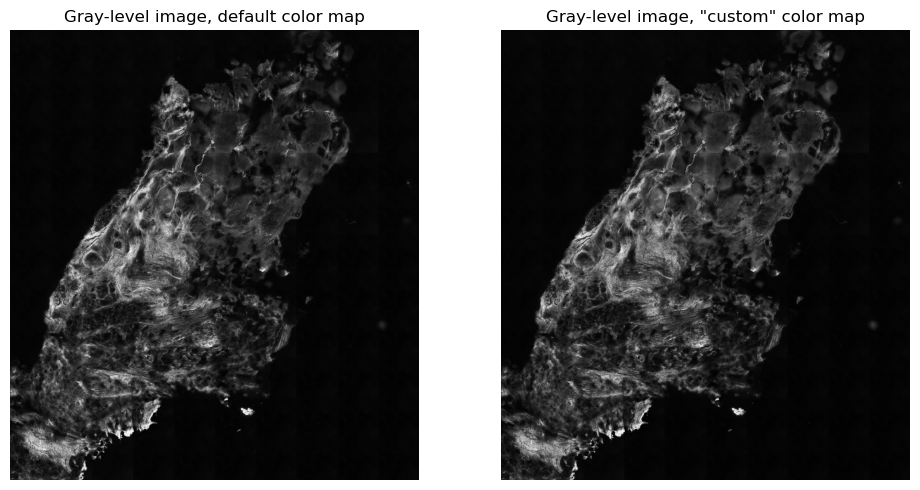

In [8]:
# Directly 
a = 0.2989
b = 0.5870
c = 1- (a+b)
image_gray1 = a * image[:,:,0] + b* image[:,:,1]+ c* image[:,:,2]

# Plot figures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title("Gray-level image, default color map")
ax[0].axis('off')

ax[1].imshow(image_gray1, cmap="gray")
ax[1].set_title("Gray-level image, \"custom\" color map")
ax[1].axis('off')
plt.tight_layout()
plt.show()

### crop image

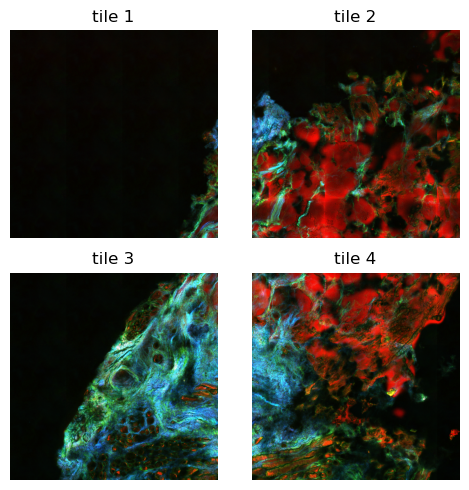

In [9]:
# Directly 
img_tile_1 = image[:500, :500, :]
img_tile_2 = image[:500, 500:1000, :]
img_tile_3 = image[500:1000, :500, :]
img_tile_4 = image[500:1000, 500:1000, :]

# Plot figures
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0, 0].imshow(img_tile_1)
ax[0, 0].set_title("tile 1")
ax[0, 0].axis("off")

ax[0, 1].imshow(img_tile_2)
ax[0, 1].set_title("tile 2")
ax[0, 1].axis("off")

ax[1, 0].imshow(img_tile_3)
ax[1, 0].set_title("tile 3")
ax[1, 0].axis("off")

ax[1, 1].imshow(img_tile_4)
ax[1, 1].set_title("tile 4")
ax[1, 1].axis("off")

plt.tight_layout()    
plt.show()

### change value of certain pixel positions

Useful to mark some areas, helpful to achieve certain aims of modelling, e.g., robustness, self-supervised learning

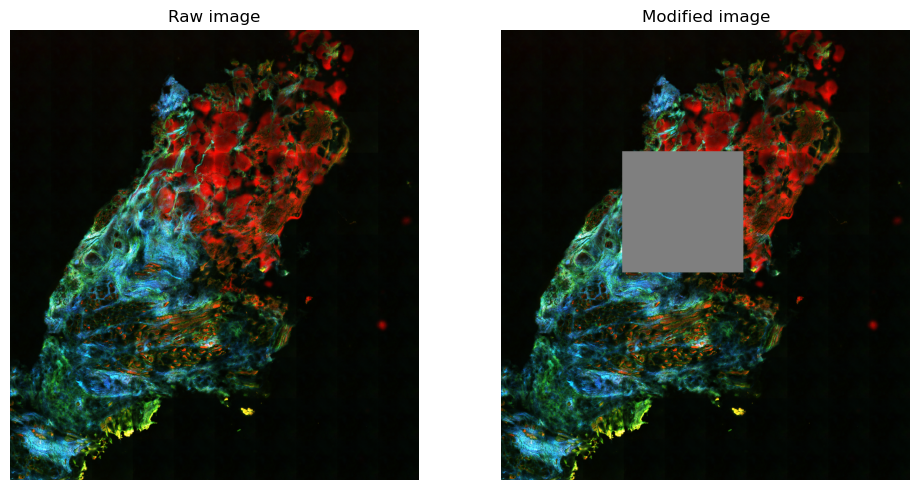

In [10]:
# Set some values to [0, 255, 0] (green)
image_change = image.copy()

image_change[400:800, 400:800] = [127., 127., 127]

# Plot figures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Raw image")
ax[0].axis('off')

ax[1].imshow(image_change, cmap="gray")
ax[1].set_title("Modified image")
ax[1].axis('off')

plt.tight_layout()
plt.show()

## Rescale resize image

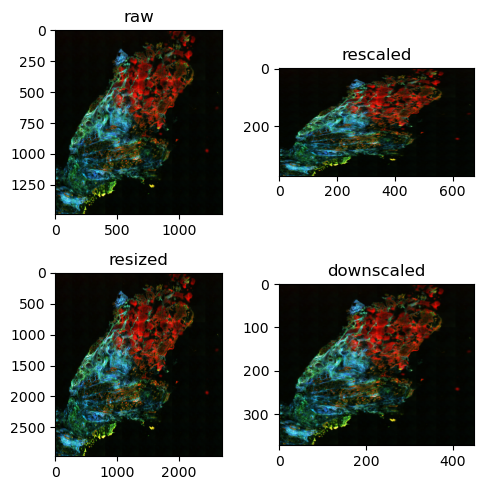

In [11]:
from skimage.transform import rescale, resize, downscale_local_mean

image_rescaled = rescale(image, (0.25, 0.5, 1), anti_aliasing=False)  ## interpolatation

image_resized = resize(image, (image.shape[0] *2, image.shape[1] *2), anti_aliasing=True)   ## interpolatation

image_downscaled = downscale_local_mean(image, factors=(4, 3, 1))   ### downscale by local average

# Plot figures
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0, 0].imshow(image)
ax[0, 0].set_title("raw")

ax[0, 1].imshow(image_rescaled)
ax[0, 1].set_title("rescaled")

ax[1, 0].imshow(image_resized)
ax[1, 0].set_title("resized")

ax[1, 1].imshow(image_downscaled/255.0)
ax[1, 1].set_title("downscaled")

plt.tight_layout()    
plt.show()

## Deep learning for image analysis

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import img_to_array, array_to_img

2025-10-08 08:59:24.814461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759913964.823704     489 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759913964.828228     489 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 08:59:24.840957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Select GPU and allow memory growth

```set_memory_growth = True``` allows for dynamic GPU memory allocation

In [13]:
# Select GPU we want to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [14]:
# Set up mixed precision policies
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## Get cifar10 dataset from keras

This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. 

<table>
<thead>
<tr>
<th align="center">Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">0</td>
<td>airplane</td>
</tr>
<tr>
<td align="center">1</td>
<td>car</td>
</tr>
<tr>
<td align="center">2</td>
<td>bird</td>
</tr>
<tr>
<td align="center">3</td>
<td>cat</td>
</tr>
<tr>
<td align="center">4</td>
<td>deer</td>
</tr>
<tr>
<td align="center">5</td>
<td>dog</td>
</tr>
<tr>
<td align="center">6</td>
<td>frog</td>
</tr>
<tr>
<td align="center">7</td>
<td>horse</td>
</tr>
<tr>
<td align="center">8</td>
<td>ship</td>
</tr>
<tr>
<td align="center">9</td>
<td>truck</td>
</tr>
</tbody>
</table>

In [15]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# we check the dataset shape
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [16]:
# Dictionary containg the sematic classes
label_dict = {0:"airplane", 1:"car", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

In [17]:
### choose part of the image to reduce calculation time
ids = np.random.randint(1, 50000, size=5000)
x_train, y_train = x_train[ids], y_train[ids]

ids = np.random.randint(1, 10000, size=1000)
x_test, y_test = x_test[ids], y_test[ids]

In [18]:
x_train = x_train/255.
x_test = x_test/255.

### Shuffle and make mini-batches

`buffer_size` determines the number of elements from which the new shuffled dataset will draw. Larger buffer sizes provide better shuffling but require more memory.

In [19]:
# # define batch size (number of samples training for iteration)
# BATCH_SIZE = 128

# # define size of the buffer to shuffle the data (optional)
# SHUFFLE_BUFFER_SIZE = 1000

# # shufle data and set batch size
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

In [20]:
### Define a neural network
def gen_model(input_size, output_size):
    
    model = tf.keras.Sequential([
            keras.Input(shape=input_size),   # set input shape
        
            keras.layers.Conv2D(64, 3, activation='relu'),      # include 2D convolutions, conv2d(n_kernels, size)
            keras.layers.Conv2D(64, 3, activation='relu'),
            keras.layers.Conv2D(64, 3, activation='relu'),
        
            keras.layers.Flatten(),          # reshape to 1D vector
        
            keras.layers.Dense(256, activation='relu'),  # Dense layer with 256 outputs, no linear activation
            keras.layers.Dense(output_size, activation='softmax')  # output layer with 10 outputs
        ])
    return model

In [21]:
input_size = (32, 32, 3)
output_size = 10
learning_rate = 0.0001

model = gen_model(input_size, output_size)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

I0000 00:00:1759913970.137900     489 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18229 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 2g.20gb, pci bus id: 0000:41:00.0, compute capability: 8.0


In [22]:
path_h5 = "shallowNet.weights.h5"
checkpointer = ModelCheckpoint(path_h5, verbose=0, save_freq="epoch", save_weights_only=True)   ### save model weights at certan frequency
history = model.fit(x_train, y_train, 
                    batch_size=16,
                    epochs=20,
                    verbose=1,     # 0-no output, 1-progress bar, 2-one line per epoch
                    validation_data=None,
                    validation_split=0.2,
                    callbacks=[checkpointer],
                    shuffle=True
                    )

Epoch 1/20


I0000 00:00:1759913971.864512     790 service.cc:148] XLA service 0x771e9800cb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759913971.864697     790 service.cc:156]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 2g.20gb, Compute Capability 8.0
2025-10-08 08:59:31.916647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759913972.083666     790 cuda_dnn.cc:529] Loaded cuDNN version 90501


 43/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2949 - sparse_categorical_accuracy: 0.1260  

I0000 00:00:1759913978.643527     790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1331 - sparse_categorical_accuracy: 0.2046

2025-10-08 08:59:41.722137: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_73', 8 bytes spill stores, 8 bytes spill loads

2025-10-08 08:59:44.313757: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_73', 4 bytes spill stores, 4 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 2.1259 - sparse_categorical_accuracy: 0.2079 - val_loss: 1.7525 - val_sparse_categorical_accuracy: 0.3680
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6153 - sparse_categorical_accuracy: 0.4206 - val_loss: 1.5949 - val_sparse_categorical_accuracy: 0.4300
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4071 - sparse_categorical_accuracy: 0.5092 - val_loss: 1.4706 - val_sparse_categorical_accuracy: 0.4750
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2185 - sparse_categorical_accuracy: 0.5925 - val_loss: 1.4760 - val_sparse_categorical_accuracy: 0.4820
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.6429 - val_loss: 1.4383 - val_sparse_categorical_accuracy: 0.4660
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8950 - sparse_categorical_accuracy: 0.7120 - val_loss: 1.4831 - val_sparse_categorical_accuracy: 0.4770
Epoch 7/20


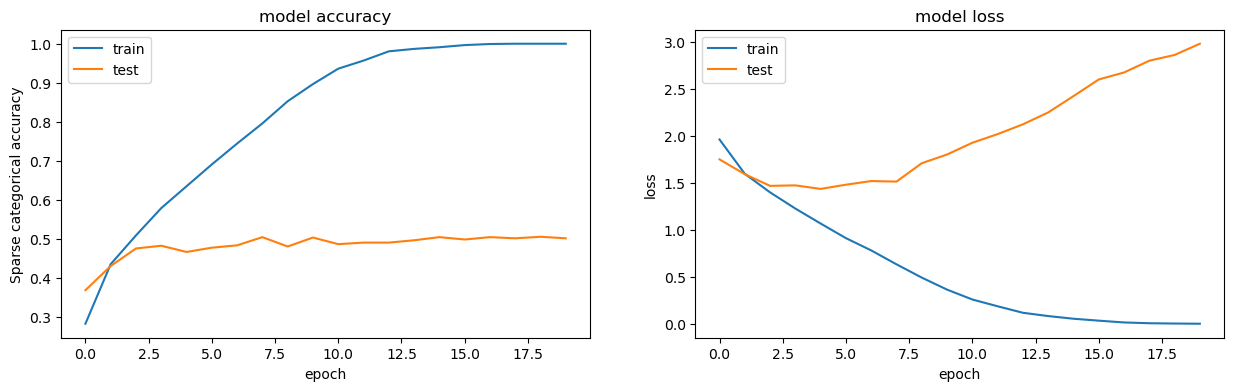

In [23]:
### plot history
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# summarize history for accuracy
ax[0].plot(history.history['sparse_categorical_accuracy'])
ax[0].plot(history.history['val_sparse_categorical_accuracy'])
ax[0].set(title='model accuracy', ylabel = 'Sparse categorical accuracy', xlabel='epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set(title='model loss', ylabel='loss', xlabel= 'epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
prediction shape :  (1000, 10)
prediction_class shape (1000,)


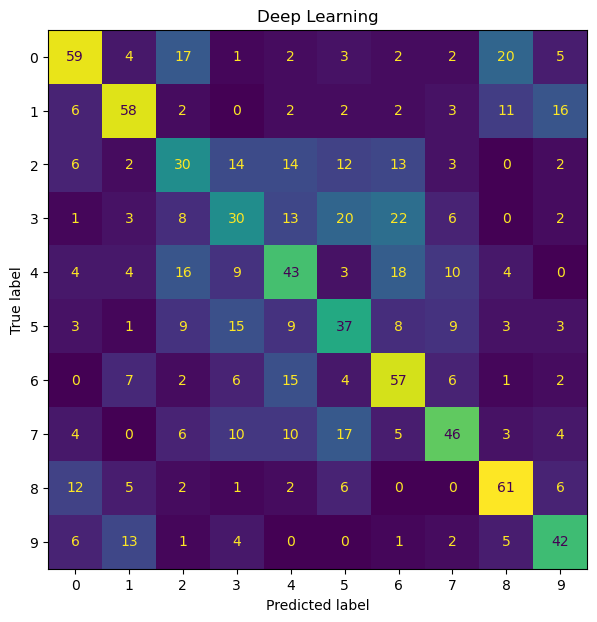

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

prediction = model.predict(x_test)
print("prediction shape : ", np.shape(prediction))

prediction_class = np.argmax(prediction, axis=-1)
print("prediction_class shape", np.shape(prediction_class))

cmat_DL = confusion_matrix(y_test, prediction_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat_DL, display_labels=np.unique(y_train))
    
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
disp.plot(ax=ax, colorbar=False)
plt.title('Deep Learning')
plt.show()


In [25]:
balanced_accuracy_score(y_test, prediction_class)

np.float64(0.4666483970132707)

### Augmentation

In [26]:
### Define a neural network

from tensorflow.keras import layers

def gen_model_aug(input_size, output_size):
    
    model = keras.Sequential([
            layers.Input(shape=input_size),   # set input shape
        

            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.2),
        
            # Convolutional layers
            layers.Conv2D(64, 3, activation="relu"),
            layers.Conv2D(64, 3, activation="relu"),
            layers.Conv2D(64, 3, activation="relu"),
        
            layers.Flatten(),          # reshape to 1D vector
        
            layers.Dense(256, activation='relu'),  
            layers.Dense(output_size, activation='softmax')  # output layer
        ])
    return model

In [27]:
input_size = (32, 32, 3)
output_size = 10
learning_rate = 0.0001

model_aug = gen_model_aug(input_size, output_size)
model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['sparse_categorical_accuracy'])

In [28]:
path_h5 = "shallowNet_aug.weights.h5"
checkpointer = ModelCheckpoint(path_h5, verbose=0, save_freq="epoch")   ### save model weights at certan frequency
history = model_aug.fit(x_train, y_train, 
                        batch_size=None,
                        epochs=20,
                        verbose=2,     # 0-no output, 1-progress bar, 2-one line per epoch
                        validation_data=None,
                        validation_split=0.2,
                        callbacks=[checkpointer],
                        shuffle=True
                        )

Epoch 1/20


125/125 - 6s - 48ms/step - loss: 2.1108 - sparse_categorical_accuracy: 0.2280 - val_loss: 1.8872 - val_sparse_categorical_accuracy: 0.3310
Epoch 2/20


125/125 - 2s - 17ms/step - loss: 1.8543 - sparse_categorical_accuracy: 0.3390 - val_loss: 1.8124 - val_sparse_categorical_accuracy: 0.3430
Epoch 3/20


125/125 - 2s - 17ms/step - loss: 1.7598 - sparse_categorical_accuracy: 0.3650 - val_loss: 1.6795 - val_sparse_categorical_accuracy: 0.4060
Epoch 4/20


125/125 - 2s - 16ms/step - loss: 1.7047 - sparse_categorical_accuracy: 0.3905 - val_loss: 1.6197 - val_sparse_categorical_accuracy: 0.4120
Epoch 5/20


125/125 - 2s - 17ms/step - loss: 1.6589 - sparse_categorical_accuracy: 0.4140 - val_loss: 1.5880 - val_sparse_categorical_accuracy: 0.4390
Epoch 6/20


125/125 - 2s - 16ms/step - loss: 1.6168 - sparse_categorical_accuracy: 0.4205 - val_loss: 1.6273 - val_sparse_categorical_accuracy: 0.3980
Epoch 7/20


125/125 - 2s - 17ms/step - loss: 1.5987 - sparse_categorical_accuracy: 0.4293 - val_loss: 1.6040 - val_sparse_categorical_accuracy: 0.4210
Epoch 8/20


125/125 - 2s - 16ms/step - loss: 1.5751 - sparse_categorical_accuracy: 0.4437 - val_loss: 1.5698 - val_sparse_categorical_accuracy: 0.4340
Epoch 9/20


125/125 - 2s - 16ms/step - loss: 1.5394 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.5304 - val_sparse_categorical_accuracy: 0.4450
Epoch 10/20


125/125 - 2s - 17ms/step - loss: 1.5292 - sparse_categorical_accuracy: 0.4692 - val_loss: 1.5779 - val_sparse_categorical_accuracy: 0.4310
Epoch 11/20


125/125 - 2s - 17ms/step - loss: 1.5157 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.5331 - val_sparse_categorical_accuracy: 0.4390
Epoch 12/20


125/125 - 2s - 17ms/step - loss: 1.4684 - sparse_categorical_accuracy: 0.4807 - val_loss: 1.5076 - val_sparse_categorical_accuracy: 0.4620
Epoch 13/20


125/125 - 2s - 16ms/step - loss: 1.4562 - sparse_categorical_accuracy: 0.4918 - val_loss: 1.4896 - val_sparse_categorical_accuracy: 0.4740
Epoch 14/20


125/125 - 2s - 16ms/step - loss: 1.4469 - sparse_categorical_accuracy: 0.4893 - val_loss: 1.4472 - val_sparse_categorical_accuracy: 0.4680
Epoch 15/20


125/125 - 2s - 18ms/step - loss: 1.4091 - sparse_categorical_accuracy: 0.4963 - val_loss: 1.4472 - val_sparse_categorical_accuracy: 0.4770
Epoch 16/20


125/125 - 2s - 17ms/step - loss: 1.3989 - sparse_categorical_accuracy: 0.5070 - val_loss: 1.5148 - val_sparse_categorical_accuracy: 0.4570
Epoch 17/20


125/125 - 2s - 17ms/step - loss: 1.3741 - sparse_categorical_accuracy: 0.5140 - val_loss: 1.4274 - val_sparse_categorical_accuracy: 0.4980
Epoch 18/20


125/125 - 2s - 16ms/step - loss: 1.3389 - sparse_categorical_accuracy: 0.5282 - val_loss: 1.4402 - val_sparse_categorical_accuracy: 0.5040
Epoch 19/20


125/125 - 2s - 16ms/step - loss: 1.3468 - sparse_categorical_accuracy: 0.5222 - val_loss: 1.5062 - val_sparse_categorical_accuracy: 0.4680
Epoch 20/20


125/125 - 2s - 16ms/step - loss: 1.3242 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.4057 - val_sparse_categorical_accuracy: 0.4940


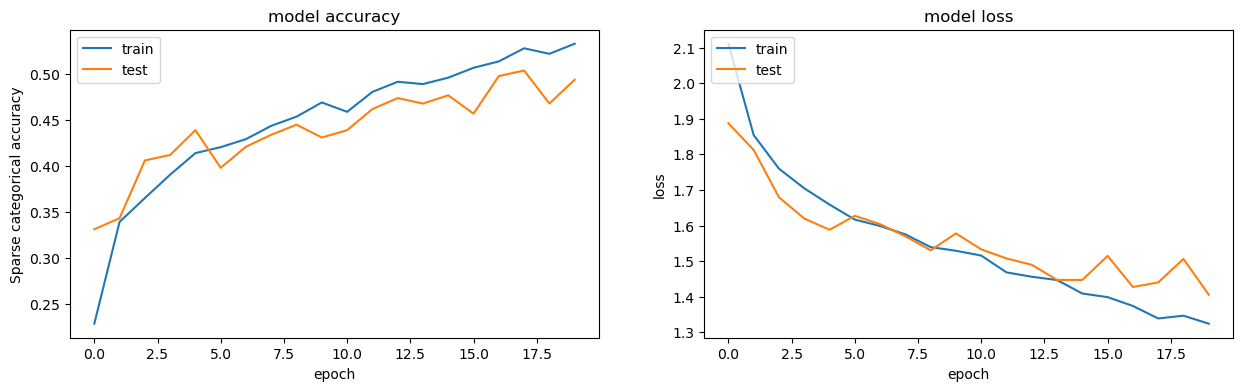

In [29]:
### plot history
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# summarize history for accuracy
ax[0].plot(history.history['sparse_categorical_accuracy'])
ax[0].plot(history.history['val_sparse_categorical_accuracy'])
ax[0].set(title='model accuracy', ylabel = 'Sparse categorical accuracy', xlabel='epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set(title='model loss', ylabel='loss', xlabel= 'epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
prediction shape :  (1000, 10)
prediction_class shape (1000,)


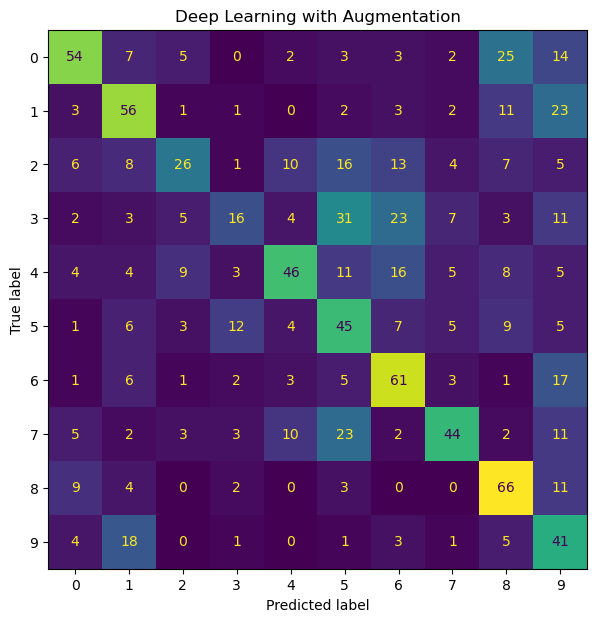

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model_aug.predict(x_test)
print("prediction shape : ", np.shape(prediction))

prediction_class = np.argmax(prediction, axis=-1)
print("prediction_class shape", np.shape(prediction_class))

cmat_DL = confusion_matrix(y_test, prediction_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat_DL, display_labels=np.unique(y_train))
    
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
disp.plot(ax=ax, colorbar=False)
plt.title('Deep Learning with Augmentation')
plt.show()

### full convolutional neural network (FCNN)

* flexible to image sizes
* cannot have any dense layers

In [31]:
def gen_model_fcnn(input_size, out_channel):
    
    model = tf.keras.Sequential([
            keras.Input(shape=input_size),   # set input shape
        
            keras.layers.Conv2D(16, 3, padding='same'),      # include 2D convolutions, conv2d(n_kernels, size)
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2D(8, 3, padding='same'),
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2DTranspose(8, 3, padding='same'),
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2DTranspose(16, 3, padding='same'),
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2D(out_channel, 3, padding='same'),
        ])
    return model

In [32]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [33]:
### choose part of the image to reduce calculation time
ids = np.random.randint(1, 60000, size=6000)
x_train, y_train = x_train[ids], y_train[ids]

ids = np.random.randint(1, 10000, size=1000)
x_test, y_test = x_test[ids], y_test[ids]

In [34]:
x_train = x_train/255.
x_test = x_test/255.

x_train = x_train[:,:, :, np.newaxis]
x_test = x_train[:,:, :, np.newaxis]

In [35]:
input_size = (None, None, 1)
output_size = 10
learning_rate = 0.0001

model_fcnn = gen_model_fcnn(input_size, 1)
model_fcnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=['mean_absolute_error'])

In [36]:
model_fcnn.fit(x_train, x_train,
              batch_size=None,
              epochs=20,
              verbose=1,     # 0-no output, 1-progress bar, 2-one line per epoch
              validation_data=None,
              validation_split=0.2,
              callbacks=None,
              shuffle=True)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.6542 - mean_absolute_error: 0.6542 - val_loss: 0.2256 - val_mean_absolute_error: 0.2256
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2795 - mean_absolute_error: 0.2795 - val_loss: 0.1755 - val_mean_absolute_error: 0.1755
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1648 - mean_absolute_error: 0.1648 - val_loss: 0.1470 - val_mean_absolute_error: 0.1470
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1198 - mean_absolute_error: 0.1198 - val_loss: 0.1090 - val_mean_absolute_error: 0.1090
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0956 - mean_absolute_error: 0.0956 - val_loss: 0.0874 - val_mean_absolute_error: 0.0874
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0800 - mean_absolute_error: 0.0800 - val_loss: 0.0767 - val_mean_absolute_error: 0.0767
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0688 - mean_absolute_error: 0.0688 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


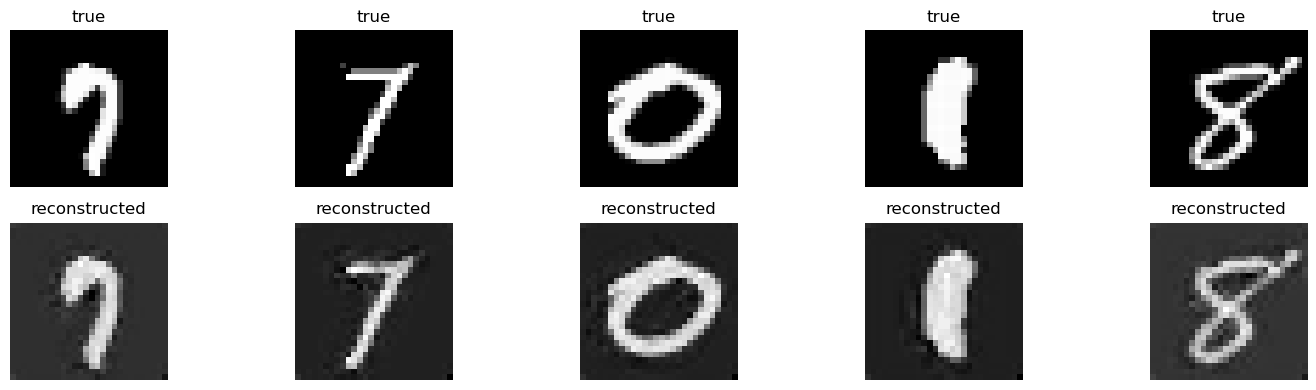

In [37]:
pred_test = model_fcnn.predict(x_test[0:5])
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 4))

for i in range(5):
    
    # summarize history for accuracy
    ax[0, i].imshow(x_test[i, :, :, 0], cmap='gray')
    ax[0, i].axis('off')
    ax[0, i].set_title('true')
    
    ax[1, i].imshow(pred_test[i, :, :, 0], cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].set_title('reconstructed')
    
plt.tight_layout()
plt.show()

### Real images
Daisuke Komura, Takumi Onoyama, Koki Shinbo, Hiroto Odaka, Minako Hayakawa, Mieko Ochi, Ranny Rahaningrum Herdiantoputri, Haruya Endo, Hiroto Katoh, Tohru Ikeda, Tetsuo Ushiku, Shumpei Ishikawa,
Restaining-based annotation for cancer histology segmentation to overcome annotation-related limitations among pathologists, Patterns, Volume 4, Issue 2, 2023, 100688, https://doi.org/10.1016/j.patter.2023.100688.

In [38]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
OUT_CHANNEL = 1   

DATA_DIR = "./data/seg_dataset"
train_images_dir = os.path.join(DATA_DIR, "train_image")
train_masks_dir  = os.path.join(DATA_DIR, "train_mask")
val_images_dir   = os.path.join(DATA_DIR, "val_image")
val_masks_dir    = os.path.join(DATA_DIR, "val_mask")
test_images_dir  = os.path.join(DATA_DIR, "test_image")
test_masks_dir   = os.path.join(DATA_DIR, "test_mask")

In [39]:
def load_image_and_mask(image_path, mask_path, img_size=IMG_SIZE):
    """Reads and preprocesses a single image and its mask."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method='nearest')
    mask = tf.cast(mask, tf.float32)
    return image, mask

In [40]:
def create_dataset(images_dir, masks_dir, batch_size=BATCH_SIZE, shuffle=True):
    """Creates tf.data.Dataset from image/mask folders."""
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.lower().endswith('.png')])
    mask_files  = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.lower().endswith('.png')])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: load_image_and_mask(x, y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_files))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset
    

#### Create datasets

In [41]:
train_ds = create_dataset(train_images_dir, train_masks_dir, shuffle=True)
val_ds   = create_dataset(val_images_dir, val_masks_dir, shuffle=False)
test_ds  = create_dataset(test_images_dir, test_masks_dir, shuffle=False)
print(train_ds.element_spec)
print(val_ds.element_spec)
print(test_ds.element_spec)


(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))


In [42]:
for img, mask in train_ds.take(1):
    print("Image shape:", img.shape, "min:", tf.reduce_min(img).numpy(), "max:", tf.reduce_max(img).numpy())
    print("Mask shape:", mask.shape, "min:", tf.reduce_min(mask).numpy(), "max:", tf.reduce_max(mask).numpy())
    print("Mask unique values:", np.unique(mask.numpy()))
    

Image shape: (8, 256, 256, 3) min: 0.02745098 max: 0.99607843
Mask shape: (8, 256, 256, 1) min: 0.0 max: 1.0
Mask unique values: [0. 1.]


2025-10-08 09:01:46.625521: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
#### Display examples

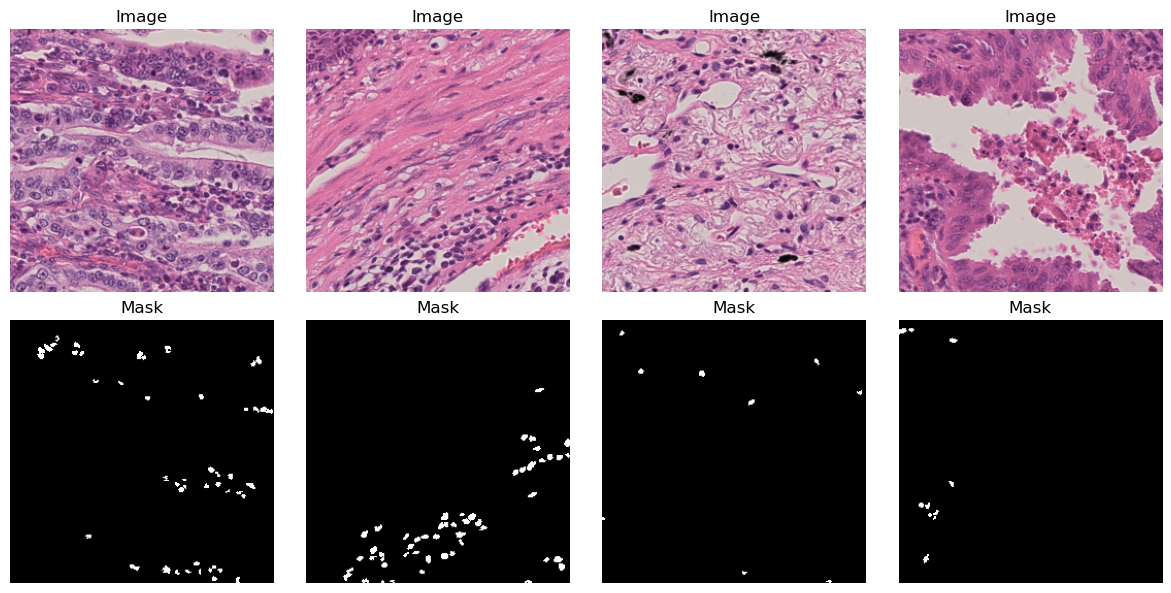

2025-10-08 09:01:53.037740: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
# Take one batch from the dataset
for images, masks in train_ds.take(1):
    # Show first 4 examples
    num_examples = 4
    plt.figure(figsize=(12, 6))
    
    for i in range(num_examples):
        # Show image
        plt.subplot(2, num_examples, i+1)
        plt.imshow(images[i].numpy())
        plt.title("Image")
        plt.axis("off")
        
        # Show corresponding mask
        plt.subplot(2, num_examples, num_examples+i+1)
        plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

#### Training

In [44]:

input_shape = (*IMG_SIZE, 3)
model_fcnn = gen_model_fcnn(input_shape, OUT_CHANNEL)

model_fcnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_fcnn.summary()


history = model_fcnn.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=8,
    epochs=20,
    shuffle=True
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256, 256, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 8)    │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256, 256, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 16)   │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697 (14.44 KB)

 Trainable params: 3,601 (14.07 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7060 - loss: 3.2422 - val_accuracy: 0.9758 - val_loss: 0.2550
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9510 - loss: 0.2689 - val_accuracy: 0.9670 - val_loss: 0.2263
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9749 - loss: 0.1763 - val_accuracy: 0.9755 - val_loss: 0.1904
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9796 - loss: 0.1492 - val_accuracy: 0.9776 - val_loss: 0.1720
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9799 - loss: 0.1415 - val_accuracy: 0.9793 - val_loss: 0.1593
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9809 - loss: 0.1349 - val_accuracy: 0.9757 - val_loss: 0.1513
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9818 - loss: 0.1222 - val_accuracy: 0.9765 - val_loss: 0.1357
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9744 - loss: 0.1341 - 

#### Show predictions

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def display_predictions(dataset, model, num_examples=5):
    dataset = dataset.unbatch().take(num_examples)  # now yields single (image, mask) pairs
    
    plt.figure(figsize=(12, num_examples * 3))
    
    for i, (image, mask_true) in enumerate(dataset):
        pred = model.predict(tf.expand_dims(image, axis=0))[0]
        
        if pred.shape[-1] == 1:
            mask_pred = (pred > 0.5).astype(np.uint8).squeeze()
            mask_true = mask_true.numpy().astype(np.uint8).squeeze()
        else:
            mask_pred = np.argmax(pred, axis=-1)
            mask_true = np.squeeze(mask_true.numpy())
        
        plt.subplot(num_examples, 3, 3*i + 1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis("off")
        
        plt.subplot(num_examples, 3, 3*i + 2)
        plt.imshow(mask_true, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        plt.subplot(num_examples, 3, 3*i + 3)
        plt.imshow(mask_pred, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


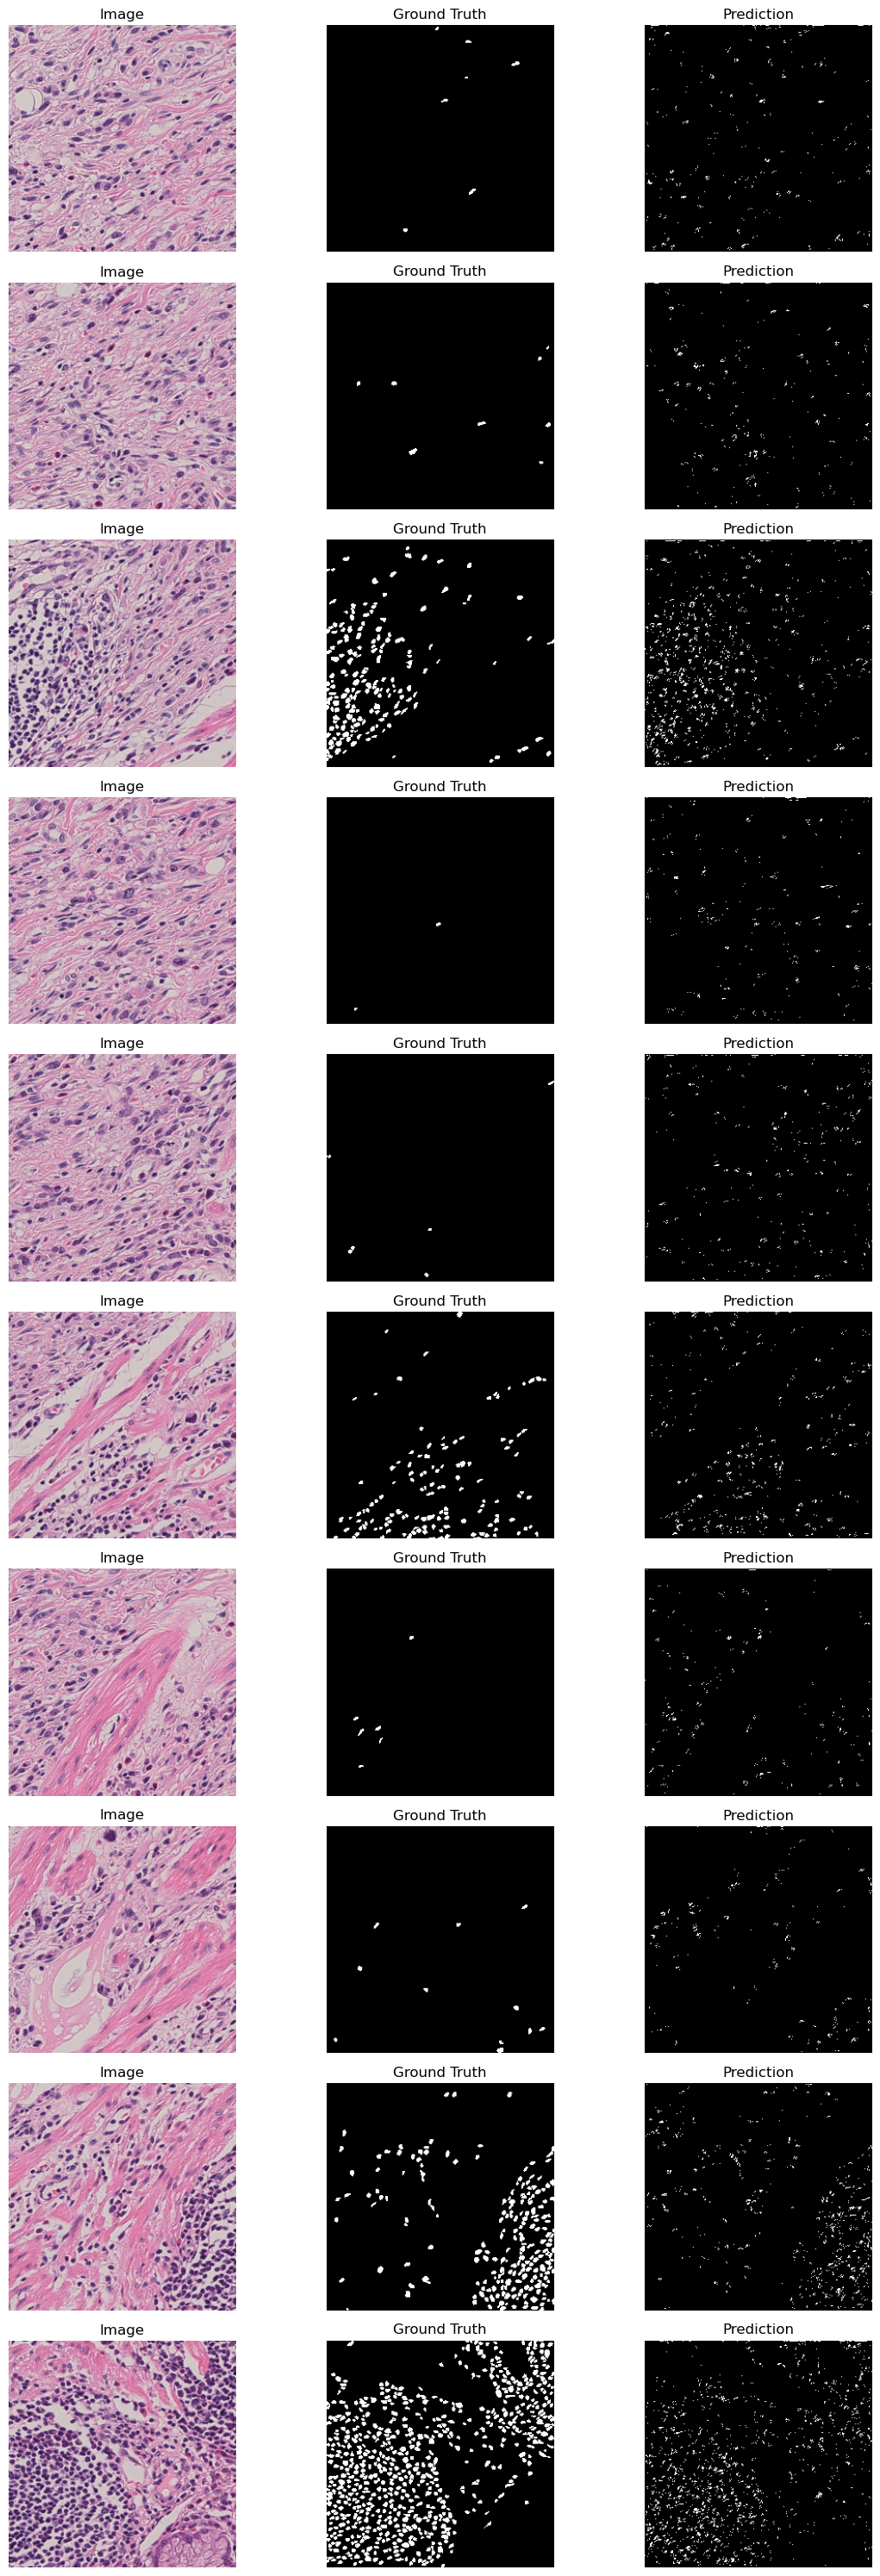

In [57]:
display_predictions(test_ds, model_fcnn, num_examples=10)